# Introdução
O acervo de dados deste projeto consiste numa rede interativa de conhecimento extraída da Wikipédia em português. Ao invés de dados estáticos, essa rede é montada dinamicamente com base nos artigos referenciados por link a partir de um artigo inicial sobre Star Wars.

Para obter os dados, empregamos um sistema automatizado de navegação (web crawl), que opera da seguinte forma:

*   O processo começa com uma página inicial, neste caso, "Star Wars".
*   O algoritmo examina o conteúdo desta página e identifica todos os links que direcionam para outros artigos dentro da Wikipédia.
*   Um link (aresta) é criado entre a página original e a página de destino, e cada artigo para o qual se aponta é adicionado à rede como um novo ponto (nó).
*   Utilizamos a Busca em Largura (BFS), e esse processo é repetido em larga escala, explorando as páginas recém-descobertas e seguindo seus respectivos links.

Para controlar a expansão da rede e garantir que seja viável executar essa análise e o tamanho da rede gerenciável, utilizamos um limite máximo para o número de nós. O resultado final é um "snapshot" da vizinhança de links relacionados a "Star Wars", que é



---


Para darmos inicio a nossa análise vamos instalar todas as dependencias para esse notebook


In [ ]:
!pip install networkx
!pip install pandas
!pip install matplotlib
!pip install python-louvain
!pip install wikipedia


  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=f64686ae6beccec6020144fe31a3c8549468dfe345c06d067baba0a9c8b401e4
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


em seguida precisamos importar todas as bibliotecas que iremoos utilziar

In [24]:
import wikipedia
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:



def get_wikipedia_links(page_title):
    try:
        wikipedia.set_lang("pt")
        page = wikipedia.page(page_title, auto_suggest=False)
        return page.links
    except wikipedia.exceptions.PageError:
        print(f"Página '{page_title}' não encontrada na Wikipedia. Verifique a grafia.")
        return []
    except wikipedia.exceptions.DisambiguationError as e:
        print(f"Página '{page_title}' é uma desambiguação. Tentando resolver...")
        if not e.options or e.options[0].strip().lower() == page_title.strip().lower():
            print(f"Desambiguação para '{page_title}' complexa ou sem opção clara. Ignorando este termo.")
            return []
        try:
            resolved_page = wikipedia.page(e.options[0], auto_suggest=False)
            print(f"Desambiguação resolvida para '{resolved_page.title}'.")
            return resolved_page.links
        except (wikipedia.exceptions.PageError, wikipedia.exceptions.DisambiguationError):
            print(f"Falha ao resolver a primeira opção de desambiguação para '{page_title}' ('{e.options[0]}'). Ignorando este termo.")
            return []
        except Exception as inner_e:
            print(f"Erro inesperado ao tentar resolver desambiguação para '{page_title}': {inner_e}")
            return []
    except Exception as e:
        print(f"Ocorreu um erro inesperado ao buscar a página: {e}")
        return []


In [26]:
def build_network_from_wikipedia(seed_page_title, max_nodes=100, max_depth=2):
    G = nx.Graph()
    pages_to_visit = [(seed_page_title, 0)]
    visited_pages = set()

    # ---  LISTA DE EXCLUSÃO  ---
    STOP_WORDS = [
        'Anexo:', 'Portal:', 'Ajuda:', 'Usuário:', 'Ficheiro:',
        'Categoria:', 'Discussão:', 'Especial:', 'Wikipedia:','fevereiro','outubro',
        'março','janeiro','julho','maio','junho','abril','agosto','dezembro','novembro','setembro', '20th Century Fox', 'Alcunha','Atari',
        'França','AdoroCinema', 'Estados Unidos','Prêmio','IMDb', 'Rotten Tomatoes','Cinema','Japão','DVD','Ficção Científica', 'Roterista','Brasil',
        'Space Opera', 'Roterista','Internacional','Ator','Wikimedia','WikiTree','MusicBrainz','Akira Kurosawa','Alec Guinness','Suécia',
        'Action Figure','Marketing','Alemanha','MTV','Marvel','Filme','3D','minuto','Adam Driver','American','Alien','Iwo Jima','IGN','Alter-ego','TV',
        'Arcade','Banda desenhada','A fortaleza escondida','Amor','Série','Disney','Antologia', 'Box office','Animação','Blockbuster',
        'Billie Lourd','Ahmed Best','Dolar','Dólar','Produtor','CNN','.com','mark hamill', 'harrison ford', 'carrie fisher', 'alec guinness',
        'peter mayhew', 'Agência Nacional','Blu-Ray','América do Sul','david prowse', 'james earl jones', 'anthony daniels', 'kenny baker',
        'peter cushing', 'Biblioteca Nacional','billy dee williams', 'ian mcdiarmid', 'frank oz', 'sebastian shaw', 'denis lawson','warwick davis',
        'liam neeson', 'ewan mcgregor', 'natalie portman', 'jake lloyd', 'hayden christensen',
        'samuel l. jackson', 'christopher lee', 'pernilla august', 'temuera morrison','jimmy smits',
        'daisy ridley', 'john boyega', 'adam driver', 'oscar isaac', 'andy serkis', 'BBC',
        'lupita', 'domhnall gleeson', 'gwendoline christie', 'max von sydow',
        'kelly marie tran', 'laura dern', 'benicio del toro',
        'felicity jones', 'diego luna', 'ben mendelsohn', 'donnie yen', 'mads mikkelsen',
        'alan tudyk', 'riz ahmed', 'forest whitaker', 'alden ehrenreich', 'woody harrelson',
        'emilia clarke', 'donald glover', 'phoebe waller-bridge', 'paul bettany'
    ]

    while pages_to_visit and len(G.nodes) < max_nodes:
        current_page_title, current_depth = pages_to_visit.pop(0)

        if current_page_title in visited_pages:
            continue

        # --- APLICA O FILTRO DE PROFUNDIDADE ---
        if current_depth >= max_depth:
            continue

        # Adiciona o nó atual ao grafo e à lista de visitados
        normalized_current_page = current_page_title.lower().strip()
        G.add_node(normalized_current_page, label=current_page_title)
        visited_pages.add(current_page_title)

        links = get_wikipedia_links(current_page_title)

        for link in links:
            # Normaliza o link para verificação
            normalized_link = link.lower().strip()

            # --- APLICA OS FILTROS DA BLACKLIST ---
            # 1. Ignora se for um número (geralmente um ano)
            if normalized_link.isnumeric():
                continue
            # 2. Ignora se corresponder a um padrão da lista de exclusão
            if any(pattern.lower().strip() in normalized_link for pattern in STOP_WORDS):
                continue
            # --- FIM DOS FILTROS ---

            # Se o link passou pelos filtros, adiciona ao grafo
            if len(G.nodes) >= max_nodes:
                break

            G.add_node(normalized_link, label=link)
            G.add_edge(normalized_current_page, normalized_link)

            if link not in visited_pages and not any(link == p[0] for p in pages_to_visit):
                pages_to_visit.append((link, current_depth + 1))

    return G

In [27]:
G = build_network_from_wikipedia("Star Wars",2000,2)

# Estrutura da rede

A estrutura da nossa rede é formada por dois elementos essenciais: **arestas** e **nós**

 **Cada nó (vértice) na rede representa um artigo distinto da Wikipédia**. Por exemplo, nosso acervo de dados inclui os nós Star Wars, Luke Skywalker, Darth Vader e Jedi. Cada um deles está ligado a uma página individual com um conjunto próprio de links e conteúdo.

**Cada aresta indica se dois artigos estão interligados por um hiperlink**. A existência de uma aresta ligando os nós A e B significa que a página A contém uma conexão com a página B, ou vice-versa. Essa conexão sugere uma forte relação temática, citação ou referência entre os dois artigos.

A rede foi modelada como um grafo não direcionado para este projeto. Como resultado, as conexões são tratadas simetricamente: independentemente da direção da citação, consideramos que há uma conexão recíproca entre "Luke Skywalker" e a página "Star Wars". Essa abordagem é ideal para explorar a coesão dessas comunidades geradas em nossa rede.

Após gerarmos a rede com a função definida anteriormente podemos ver que temos {num_edges} arestas e {num_nodes} nodos


In [28]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Após gerarmos a rede com a função definida anteriormente podemos ver que temos {num_edges} arestas e {num_nodes} nodos")

Após gerarmos a rede com a função definida anteriormente podemos ver que temos 6286 arestas e 2000 nodos


In [29]:
# prompt: O primeiro filtro que aplicamos durante nossa análise, acontece durante a coleta, aplicamos o parâmetro “max_nodes” para definirmos um filtro de escopo, limitando o tamanho da nossa rede (de certa forma, podemos chamar esse filtro de “fronteira” da rede), ele impede que o nosso crawler perca o escopo da análise e acabe mapeando uma porção gigantesca da Wikipédia.
# Em seguida utilizamos uma array repleta de “stop words” para filtrar diretamente alguns termos que levariam o web crawler a se aprofundar em assuntos que não estão no escopo escolhido (inclusive um nodo em específico chamou minha atenção durante a criação desta lista, mais a frente falarei sobre o que encontrei).

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Após gerarmos a rede com a função definida anteriormente podemos ver que temos {num_edges} arestas e {num_nodes} nodos")


Após gerarmos a rede com a função definida anteriormente podemos ver que temos 6286 arestas e 2000 nodos


# Filtros
O primeiro filtro que aplicamos durante nossa análise, acontece durante a coleta.

> podemos vê-lo na assinatura da função build_network_from_wikipedia

aplicamos o parâmetro “max_nodes” para definirmos um filtro de escopo, limitando o tamanho da nossa rede (de certa forma, podemos chamar esse filtro de “fronteira” da rede), ele impede que o nosso crawler perca o escopo da análise e acabe mapeando uma porção gigantesca da Wikipédia.

Junto a esse filtro, tambem aplicamos um filtro de profundidade, para imperdirmos que mesmo que algum nó que não queremos em nossa rede apareça, ele não trára outros nós que estejam partindo dele

Além dos mencionados, utilizamos uma array repleta de “stop words” para filtrar diretamente alguns termos que levariam o web crawler a se aprofundar em assuntos que não estão no escopo escolhido (inclusive um nodo em específico chamou minha atenção durante a criação desta lista, mais a frente falarei sobre o que encontrei).



In [ ]:
STOP_WORDS = [
        'Anexo:', 'Portal:', 'Ajuda:', 'Usuário:', 'Ficheiro:',
        'Categoria:', 'Discussão:', 'Especial:', 'Wikipedia:','fevereiro','outubro',
        'março','janeiro','julho','maio','junho','abril','agosto','dezembro','novembro','setembro', '20th Century Fox', 'Alcunha','Atari',
        'França','AdoroCinema', 'Estados Unidos','Prêmio','IMDb', 'Rotten Tomatoes','Cinema','Japão','DVD','Ficção Científica', 'Roterista','Brasil',
        'Space Opera', 'Roterista','Internacional','Ator','Wikimedia','WikiTree','MusicBrainz','Akira Kurosawa','Alec Guinness','Suécia',
        'Action Figure','Marketing','Alemanha','MTV','Marvel','Filme','3D','minuto','Adam Driver','American','Alien','Iwo Jima','IGN','Alter-ego','TV',
        'Arcade','Banda desenhada','A fortaleza escondida','Amor','Série','Disney','Antologia', 'Box office','Animação','Blockbuster',
        'Billie Lourd','Ahmed Best','Dolar','Dólar','Produtor','CNN','.com','mark hamill', 'harrison ford', 'carrie fisher', 'alec guinness',
        'peter mayhew', 'Agência Nacional','Blu-Ray','América do Sul','david prowse', 'james earl jones', 'anthony daniels', 'kenny baker',
        'peter cushing', 'Biblioteca Nacional','billy dee williams', 'ian mcdiarmid', 'frank oz', 'sebastian shaw', 'denis lawson','warwick davis',
        'liam neeson', 'ewan mcgregor', 'natalie portman', 'jake lloyd', 'hayden christensen',
        'samuel l. jackson', 'christopher lee', 'pernilla august', 'temuera morrison','jimmy smits',
        'daisy ridley', 'john boyega', 'adam driver', 'oscar isaac', 'andy serkis', 'BBC','roupa','mais rápido que a luz',
        'lupita', 'domhnall gleeson', 'gwendoline christie', 'max von sydow',
        'kelly marie tran', 'laura dern', 'benicio del toro',
        'felicity jones', 'diego luna', 'ben mendelsohn', 'donnie yen', 'mads mikkelsen',
        'alan tudyk', 'riz ahmed', 'forest whitaker', 'alden ehrenreich', 'woody harrelson',
        'emilia clarke', 'donald glover', 'phoebe waller-bridge', 'paul bettany'
    ]

In [36]:
ordem_dos_nos = list(G.nodes())
matriz_adjacencia = nx.to_numpy_array(G, nodelist=ordem_dos_nos)
df_adj = pd.DataFrame(matriz_adjacencia, index=G.nodes(), columns=G.nodes())
display(df_adj)

,star wars,a-wing,a vingança dos sith,ahsoka tano,alderaan,aliança rebelde,almirante ackbar,anakin skywalker,armitage hux,ataque dos clones,...,destroy build destroy,discovery+,discovery channel,discovery civilization,discovery familia,discovery family,discovery geschichte,discovery hd,discovery health channel,discovery history
star wars,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a-wing,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a vingança dos sith,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ahsoka tano,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
alderaan,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
discovery family,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
discovery geschichte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
discovery hd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
discovery health channel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
periphery = 0
if G.number_of_nodes() > 0:
        if nx.is_connected(G):
            component_to_analyze = G
            print("A rede é totalmente conectada. As métricas foram calculadas para o grafo completo.")
        else:
            print("A rede não é conectada. As métricas abaixo foram calculadas para o Maior Componente Conectado.")

            # Pega o maior componente conectado
            largest_cc_nodes = max(nx.connected_components(G), key=len)
            component_to_analyze = G.subgraph(largest_cc_nodes)

        try:
            # Calcular o diâmetro
            diameter = nx.diameter(component_to_analyze)
            print(f"Diâmetro da Rede: {diameter}")
            # Calcular a periferia
            periphery = nx.periphery(component_to_analyze)

        except Exception as e:
            print(f"Não foi possível calcular o diâmetro/periferia: {e}")
else:
      print("Grafo vazio, não é possível calcular diâmetro ou periferia.")

A rede é totalmente conectada. As métricas foram calculadas para o grafo completo.
Diâmetro da Rede: 4


O **diâmetro** é a maior "distância mais curta" entre quaisquer dois nós na rede.

Ele nos dá uma ideia do "quão grande" a rede é em termos de passos para atravessá-la.


In [43]:
print(periphery[:10])


['avião de intercepção', 'avião de reconhecimento', 'mais rápido que a luz', 'reconhecimento em força', 'star wars battlefront ii (jogo eletrônico de 2017)', 'stuff.co.nz', '60 minutes', 'a. o. scott', 'a ameaça fantasma', 'a roupa nova do rei']


A **periferia** é o conjunto de nós que estão nas "bordas" da rede. Eles
são os nós com a maior excentricidade (a distância máxima para qualquer outro nó).

Podemos ver que mesmo após todos os filtros, alguns nós que não estão inclusos no escopo de star wars ainda aparecem, nosso algoritimo de filtragem ainda precisa ser melhorado!

# Esparsidade/Densidade da Rede
**Valor Obtido: 0.0031**

A densidade de uma rede mede o quão conectada ela é. É a razão entre o número de conexões que a rede realmente tem e o número máximo de conexões que ela poderia ter. Um valor de 1 significa que cada nó está conectado a todos os outros (rede completa), enquanto um valor de 0 significa que não há nenhuma conexão.

Em nossa rede temos um valor de 0.0031 é extremamente baixo, muito próximo de zero. Isso significa que a rede possui apenas 0.31% de todas as conexões possíveis.

Assim podemos concluir que a rede é extremamente esparsa. Esta é uma característica marcante que indica que as conexões são seletivas e não aleatórias; uma página não se conecta a todas as outras, mas apenas àquelas que são tematicamente mais relevantes. A esparsidade, neste caso, mostra uma estrutura de informação organizada e lógica.


#Assortatividade Geral da rede
A **assortatividade** mede a tendência de nós com graus semelhantes se conectarem.
- Um valor **positivo** indica que nós de alto grau tendem a se conectar com outros nós de alto grau (redes 'ricas ficam mais ricas').
- Um valor **negativo** indica que nós de alto grau tendem a se conectar com nós de baixo grau (redes 'centralizadas').
- Um valor **próximo de zero** indica uma mistura aleatória.


In [44]:
if num_nodes > 1 and num_edges > 0:
      assortativity = nx.degree_assortativity_coefficient(G)
      print(f"**Coeficiente de Assortatividade de Grau:** `{assortativity:.4f}`")
else:
    print("Não é possível calcular a Assortatividade para este grafo (poucos nós/arestas).")

**Coeficiente de Assortatividade de Grau:** `-0.7100`


No nosso caso podemos ver que temos uma rede com um grau de assortatividade negativo, o que indica que nossa rede é centralizada, ou seja, nós com um alto número de conexões (alto grau) tendem a se conectar com nós que têm poucas conexões (baixo grau). Esse valor negativo forte indica uma estrutura bem definida de "centro e periferia", poucos nós centrais se conectam a muitos nós periféricos.

Podemos visualizar isso na imagem a seguir, o nodos, tem seus tamanhos propocionais ao seu grau, ficando bem evidente que temos poucos nós de grau alto se conectando a varios nós de baixo grau

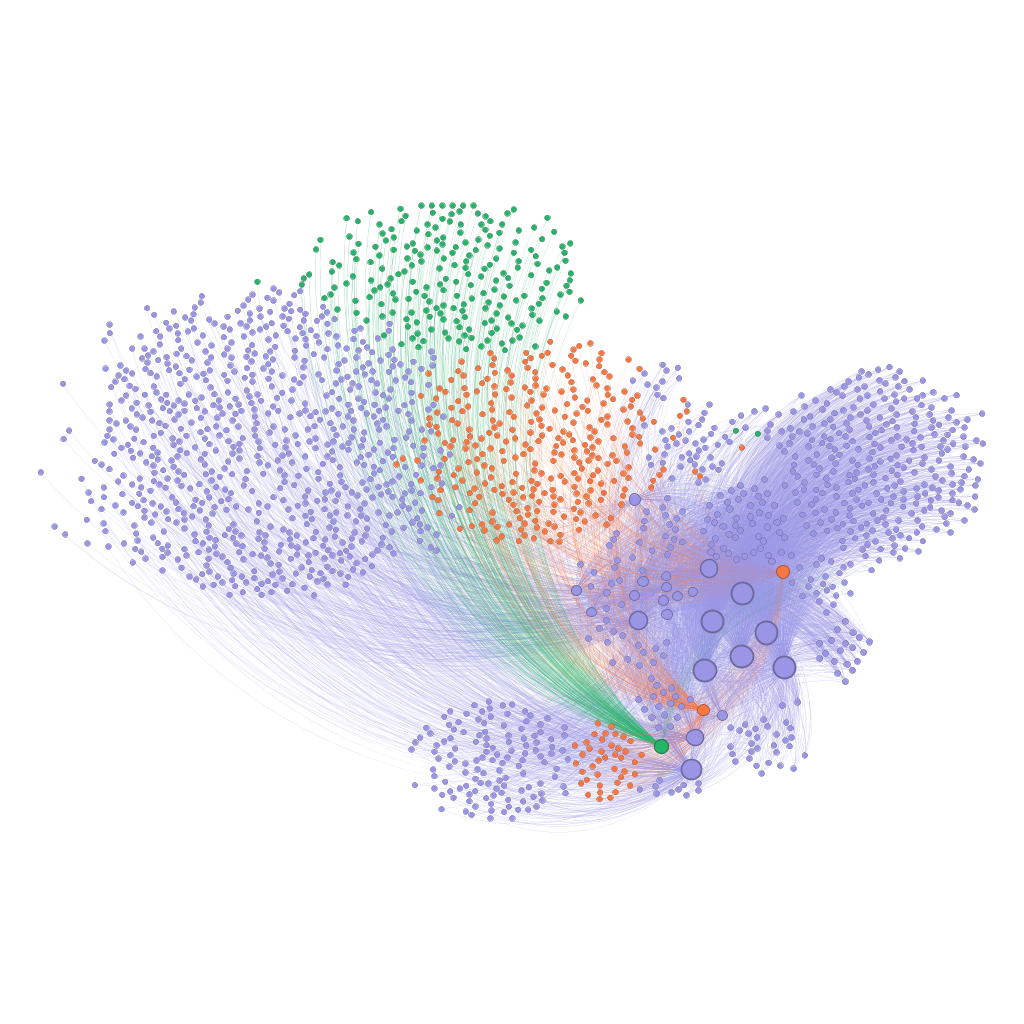

# Histograma da Distribuição de Grau
O **Histograma da Distribuição de Grau** mostra a frequência com que cada grau (número de conexões) aparece na rede.

 Pelo o que pesquisei sobre outras analises de redes como a Wikipedia (muitas vezes consideradas redes de mundo pequeno ou livres de escala), é comum ver muitos nós com poucos graus e poucos nós (os "hubs") com graus muito altos, resultando em uma distribuição com uma "cauda longa" para a direita.

In [52]:
# Extrai a lista de graus de todos os nós do grafo
all_degrees = [degree for node, degree in G.degree()]

# Verifica se a lista de graus não está vazia antes de prosseguir
if all_degrees:
    # Calcula o grau mínimo e máximo
    min_degree = min(all_degrees)
    max_degree = max(all_degrees)

    # Lógica para definir os 'bins' (intervalos) e 'ticks' (marcas no eixo) do histograma
    if min_degree == max_degree:
        # Caso especial: todos os nós têm o mesmo grau
        bins_range = [min_degree - 0.5, max_degree + 0.5]
        tick_values = [min_degree]
    elif max_degree - min_degree < 10:
        # Caso para uma pequena variação de graus
        bins_range = range(min_degree, max_degree + 2)
        tick_values = range(min_degree, max_degree + 1)
    else:
        # Caso para uma grande variação de graus
        bins_range = range(min_degree, max_degree + 2)
        # Calcula um passo para os ticks para não poluir o eixo x
        ideal_num_ticks = 10
        step = max(1, (max_degree - min_degree) // ideal_num_ticks)
        tick_values = range(min_degree, max_degree + 1, step)



### Plotando o gráfico

Primeiro precisamos definir títulos e rótulos dos eixos.

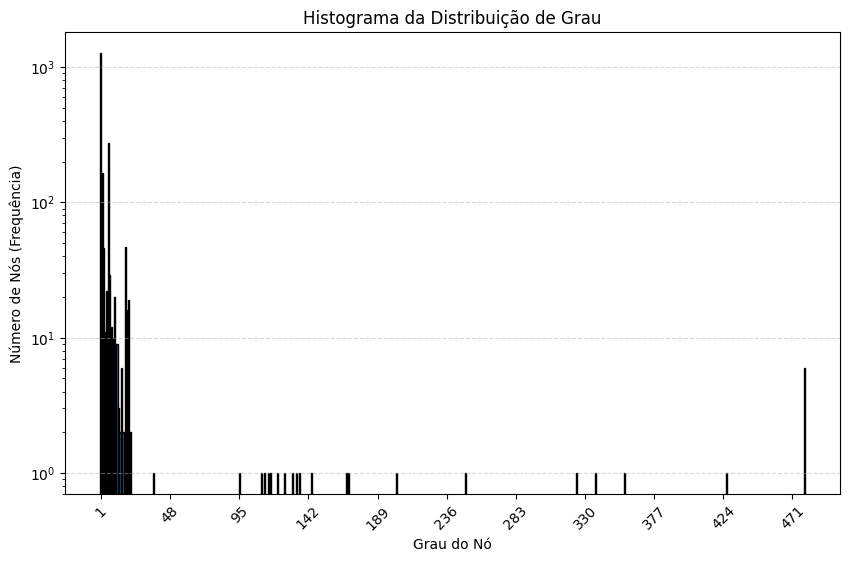

In [53]:
# Verifica se a variável all_degrees foi criada e não está vazia
if 'all_degrees' in locals() and all_degrees:

    # Primeiro precisamos definir títulos e rótulos dos eixos.
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(all_degrees, bins=bins_range, edgecolor='black', align='left', rwidth=0.8)
    ax.set_title('Histograma da Distribuição de Grau')
    ax.set_xlabel('Grau do Nó')
    ax.set_ylabel('Número de Nós (Frequência)')

    # Em seguida iremos aplicar a escala logarítmica no eixo y para uma melhor visualização das distribuições de grau
    ax.set_yscale('log')

    # Define as marcas no eixo x com base nos valores calculados anteriormente
    ax.set_xticks(list(tick_values))
    ax.tick_params(axis='x', rotation=45) # Rotaciona os ticks se forem muitos

    # Adiciona grid para facilitar a leitura
    ax.grid(axis='y', alpha=0.5, linestyle='--')

    # Finalmente, exibe o gráfico. Este comando deve estar na mesma célula.
    plt.show()

else:
    print("Execute a primeira célula para gerar os dados do grafo antes de plotar.")

# Coeﬁcientes de clustering local



1.   Coeficiente de Clustering para o nó 'armitage hux': 0.0323
3.   Coeficiente de Clustering para o nó 'cad bane': 0.0323
5.   Coeficiente de Clustering para o nó 'o ataque dos clones': 1.0000



Este valor mede a probabilidade de que dois vizinhos do nó selecionado também sejam vizinhos entre si. Em outras palavras, ele indica o quão "fechado" é o grupo de amigos diretos deste nó.


*    Um valor próximo de 1 significa que a vizinhança do nó é muito unida, quase um "clique".
*    Um valor próximo de 0 significa que os vizinhos do nó não se conectam entre si.


In [57]:
local_clustering_coeff = nx.clustering(G, "armitage hux")
print(f"**Coeficiente de Clustering para o nó 'armitage hux':** `{local_clustering_coeff:.4f}`")

**Coeficiente de Clustering para o nó 'armitage hux':** `0.0323`


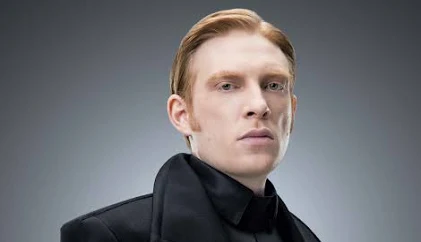

In [59]:
local_clustering_coeff = nx.clustering(G, "capitã phasma")
print(f"**Coeficiente de Clustering para o nó 'capitã phasma':** `{local_clustering_coeff:.4f}`")

**Coeficiente de Clustering para o nó 'capitã phasma':** `0.0323`


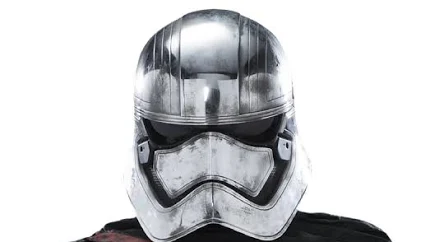

In [62]:
local_clustering_coeff = nx.clustering(G, "cad bane")
print(f"**Coeficiente de Clustering para o nó 'cad bane':** `{local_clustering_coeff:.4f}`")

**Coeficiente de Clustering para o nó 'cad bane':** `0.0323`


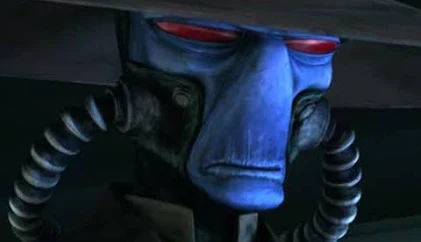

In [67]:
local_clustering_coeff = nx.clustering(G, "o ataque dos clones")
print(f"**Coeficiente de Clustering para o nó 'o ataque dos clones':** `{local_clustering_coeff:.4f}`")

**Coeficiente de Clustering para o nó 'o ataque dos clones':** `1.0000`


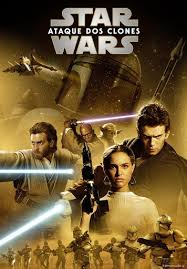

#Coeficiente de Clustering Global

Coeficiente de Clustering Global: 0.3144

---



O coeficiente de clustering global indica a probabilidade de que os vizinhos de um nó também sejam vizinhos entre si, formando "triângulos" ou "cliques". Um valor alto sugere que a rede é composta por comunidades ou grupos coesos (como esperamos que um grupo de artigos seja).

Isso é um sinal de de que nossa rede é uma estrutura de "Mundo Pequeno" (Small-World):

Redes do tipo "mundo pequeno", que são muito comuns em sistemas reais (redes sociais, biológicas, etc.), são caracterizadas por terem um coeficiente de clustering significativamente mais alto que o de uma rede aleatória, ao mesmo tempo que mantêm um caminho médio entre os nós relativamente curto.

O valor de 0.3144 é um forte indicativo de que nossa rede provavelmente possui essa propriedade de "mundo pequeno".

# Componente Conectado / Componente Fracamente conectado
  
  Um **Componente Conectado** é um subgrafo onde cada nó pode ser alcançado a partir de qualquer outro.
  Como nossa rede é **não-dirigida** (as conexões não tem direção), este é o principal conceito de conectividade.
  Para este tipo de grafo, os "Componentes Conectados" são equivalentes aos **"Componentes Conectados Fracamente" (WCCs)** que existem em grafos dirigidos.


> Número de Componentes Conectados (WCCs): 1



In [69]:
from IPython.display import display


print("--- Análise de Componentes Conectados ---")

# Verifica a conectividade do grafo
if nx.is_connected(G):
    print("\nRESULTADO: O grafo é totalmente conectado e possui apenas 1 componente.")
    # Se for conectado, o LCC é o próprio grafo
    LCC = G.copy()

else:
    # Se for desconectado, lista e analisa todos os componentes
    # Ordena os componentes por tamanho (do maior para o menor) para fácil identificação
    componentes = sorted(list(nx.connected_components(G)), key=len, reverse=True)

    print(f"\nRESULTADO: O grafo é desconectado e possui {len(componentes)} componentes.")

    # Prepara os dados para criar uma tabela informativa com pandas
    dados_componentes = []
    for i, nos_do_componente in enumerate(componentes):
        tamanho = len(nos_do_componente)
        amostra_nos = list(nos_do_componente)[:5] # Pega os 5 primeiros nós como amostra

        dados_componentes.append({
            "ID do Componente": i,
            "Nº de Nós": tamanho,
            "Observação": "Maior Componente Conectado (LCC)" if i == 0 else f"Componente Menor #{i}",
            "Nós de Amostra": amostra_nos
        })

    # Cria e exibe o DataFrame
    df_componentes = pd.DataFrame(dados_componentes)

    print("\nTabela de Componentes da Rede (do maior para o menor):")


    maior_componente_nodes = componentes[0]
    subgraph_maior_componente_nodes = G.subgraph(maior_componente_nodes).copy()
    df_componentes.show()


--- Análise de Componentes Conectados ---

RESULTADO: O grafo é totalmente conectado e possui apenas 1 componente.


# Degree centrality.

In [72]:
degree_centrality = nx.degree_centrality(G)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_degree_topk = pd.DataFrame(sorted_degree, columns=['Nó', 'Centralidade de Grau'])
pd.DataFrame(df_degree_topk)

,Nó,Centralidade de Grau
0,armitage hux,0.239620
1,bastila shan,0.239620
2,bib fortuna,0.239620
3,cad bane,0.239620
4,capitã phasma,0.239620
5,capitão rex,0.239620
6,a vingança dos sith,0.213107
7,star wars,0.178589
8,ataque dos clones,0.168584
9,anakin skywalker,0.162081


# Betweenness Centrality

In [73]:
# Centralidade de Intermediação (Betweenness Centrality)

betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_betweenness_topk = pd.DataFrame(sorted_betweenness, columns=['Nó', 'Centralidade de Intermediação'])
pd.DataFrame(df_betweenness_topk)



,Nó,Centralidade de Intermediação
0,star wars,0.373459
1,a vingança dos sith,0.211736
2,captain eo,0.202008
3,anakin skywalker,0.199493
4,cbs,0.172105
5,ataque dos clones,0.143211
6,cartoon network,0.139663
7,buster crabbe,0.098494
8,armitage hux,0.047600
9,bastila shan,0.047600


# Closeness Centrality

In [74]:
# Centralidade de Proximidade (Closeness Centrality)

closeness_centrality = nx.closeness_centrality(G)
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_closeness_topk = pd.DataFrame(sorted_closeness, columns=['Nó', 'Centralidade de Proximidade'])
pd.DataFrame(df_closeness_topk)

,Nó,Centralidade de Proximidade
0,star wars,0.549025
1,anakin skywalker,0.481339
2,a vingança dos sith,0.459857
3,george lucas,0.445509
4,ataque dos clones,0.445311
5,armitage hux,0.445013
6,bastila shan,0.445013
7,bib fortuna,0.445013
8,cad bane,0.445013
9,capitã phasma,0.445013


# Eigenvector Centrality

In [75]:
 # Centralidade de Vetor Próprio (Eigenvector Centrality)

eigenvector_centrality = nx.eigenvector_centrality(G)
sorted_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_eigenvector_topk = pd.DataFrame(sorted_eigenvector, columns=['Nó', 'Centralidade de Vetor Próprio'])
pd.DataFrame(df_eigenvector_topk)

,Nó,Centralidade de Vetor Próprio
0,armitage hux,0.255276
1,bastila shan,0.255276
2,bib fortuna,0.255276
3,cad bane,0.255276
4,capitã phasma,0.255276
5,capitão rex,0.255276
6,star wars,0.150009
7,anakin skywalker,0.128066
8,alderaan,0.116203
9,c-3po,0.111981


# Conclusão: Quem são os mais importantes?

A gente não tem como definir um nodo como o mais importante, mas podemos eleger um "Conselho Jedi" de nós importantes, cada um com um papel:

* O Centro do Universo (star wars): O melhor para espalhar informação (maior Proximidade).

* O Herói e a Ponte (anakin skywalker): Importante em quase todas as métricas, crucial para conectar as eras (desde as prequels até a mais nova trilogia) (alta Intermediação).

* Os Embaixadores do Mundo Real (cbs, cartoon network): As pontes mais críticas que conectam a ficção com o mundo da mídia (2 grandes canais de comunicação que transmitiram durante anos as series animadas na tv).

* Os Lordes Feudais (Armitage Hux, capitão Rex, etc.): Os nós mais influentes e populares (inclusive meu personagem favorito é o capitão Rex) dentro de seus próprios "feudos" ou comunidades (primeira ordem e Exercíto da República) (maior Grau e Vetor Próprio).

In [79]:

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import community as community_louvain
from IPython.display import display, IFrame, Markdown
import os

df_centrality = pd.DataFrame({
    'degree': degree_centrality,
    'betweenness': betweenness_centrality,
    'closeness': closeness_centrality,
    'eigenvector': eigenvector_centrality
})

#Roda o algoritmo Louvain para encontrar a melhor partição (comunidades)
partition = community_louvain.best_partition(LCC, random_state=42)

#Relatório básico dos resultados
num_communities = len(set(partition.values()))
print(f"\nRESULTADO: Foram detectadas {num_communities} comunidades distintas na rede.")

#Análise do tamanho das comunidades
print("\nAnálise do Tamanho das 10 Maiores Comunidades:")
community_counts = Counter(partition.values())
df_communities = pd.DataFrame(community_counts.most_common(10), columns=['ID da Comunidade', 'Número de Nós'])
display(df_communities)


RESULTADO: Foram detectadas 8 comunidades distintas na rede.

Análise do Tamanho das 10 Maiores Comunidades:


,ID da Comunidade,Número de Nós
0,2,529
1,6,338
2,0,319
3,4,280
4,5,216
5,7,175
6,3,112
7,1,31


# Sobre o nó que me chamou mais atenção durante o estudo

Duante a construção desta rede, econtrei um nó chamado "CIA" e achei isso muito esquisito "como que star wars está ligado com o CIA? algum nó bagunçando a rede? alguma conspiração maluca?". Acontece que a um certo tempo atrás (anos 2000), a CIA administrava um site para fãs de star wars, um forum dedicado a esse universo. O site se chamava StarWarsWeb.net, nele haviam varios anuncios dos futuros jogos da franquia,fotos dos personagens postagens e discussões de fãs, aí você se pergunta "o que a CIA queria com um site feito para fãs de star wars?" acontece que  eles utiliazavam este site, para mandar mensagens entre agentes e alem dos fãs que usavam esse site, os agentes da CIA conseguiam acessar esse portal confidencial inserindo uma senha na barra de busca do site.


> Por trás da fachada, o site escondia um sistema de mensagens secretas. Bastava digitar uma senha específica na barra de busca da página para que aparecesse uma janela de comunicação oculta.

Felizmente ainda é possivel acessar o site através de ferramentas como a WayBackMachine.

Achei uma história interessante e me fez pensar quantos outros sites que eu uso podem ser parte de alguma conspiração?

fontes:
* https://www.brasilparalelo.com.br/noticias/cia-usava-site-de-star-wars-para-se-comunicar-com-espioes
* https://www.tabnews.com.br/NewsletterOficial/cia-usava-site-de-star-wars-para-se-comunicar-secretamente-com-espioes
* https://revistamonet.globo.com/noticias/noticia/2025/05/cia-colocou-no-ar-site-para-fas-de-star-wars-para-se-comunicar-com-espioes-do-mundo-todo-entenda.ghtml

